## Simple data representations

Before we delve into learnable data representations, feature crosses, etc., let’s look at simpler data representations. We can think of these simple data representations as common idioms in machine learning -- not quite patterns, but commonly employed solutions nevertheless.

## Scaling helps

Models trained with scaled data converge faster and are therefore faster/cheaper to train.

In [1]:
from sklearn import datasets, linear_model
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)

In [2]:
raw = diabetes_X[:, None, 2]

max_raw = max(raw)
min_raw = min(raw)
scaled = (2*raw - max_raw - min_raw)/(max_raw - min_raw)

In [3]:
def train_raw():
    linear_model.LinearRegression().fit(raw, diabetes_y)

def train_scaled():
    linear_model.LinearRegression().fit(scaled, diabetes_y)

import timeit
raw_time = timeit.timeit(train_raw, number=1000)
scaled_time = timeit.timeit(train_scaled, number=1000)
print('Raw: {:.4f}s, Scaled: {:.4f}s, Improvement: {:2f}%'
      .format(raw_time, scaled_time, 100*(raw_time-scaled_time)/raw_time))

Raw: 0.3075s, Scaled: 0.2774s, Improvement: 9.792116%


## Numerical inputs

One key predictor of the weight of a baby is the mother's age. We can verify this by looking at the average weight of a baby born to mothers with different ages. Since the dataset is large enough, we will do the computation in BigQuery:

In [4]:
%%bigquery df
SELECT
  mother_age,
  COUNT(1) AS num_babies,
  AVG(weight_pounds) AS avg_wt
FROM
  publicdata.samples.natality
WHERE
  year > 2000
GROUP BY mother_age
ORDER BY mother_age

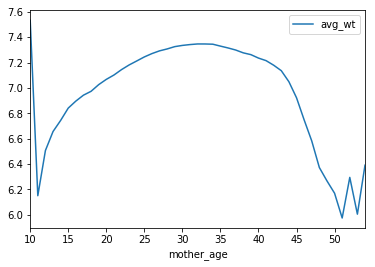

In [5]:
df.plot(x='mother_age', y='avg_wt');

Looking at the distribution (histogram) of the raw mother's age makes the weird behavior at the edges clear. We don't have enough data for mothers in their low-teens and in their fifties. In statistical terms, these are outliers.

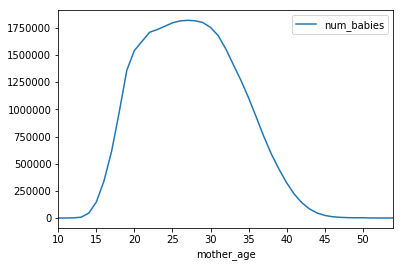

In [6]:
df.plot(x='mother_age', y='num_babies');

Let's look at the data after applying different forms of scaling.

In [7]:
base_sql = """
CREATE TEMPORARY FUNCTION CLIP_LESS(x FLOAT64, a FLOAT64) AS (
  IF (x < a, a, x)
);
CREATE TEMPORARY FUNCTION CLIP_GT(x FLOAT64, b FLOAT64) AS (
  IF (x > b, b, x)
);
CREATE TEMPORARY FUNCTION CLIP(x FLOAT64, a FLOAT64, b FLOAT64) AS (
  CLIP_GT(CLIP_LESS(x, a), b)
);

WITH stats AS (
    SELECT
      MIN(mother_age) AS min_age,
      MAX(mother_age) AS max_age,
      AVG(mother_age) AS avg_age,
      STDDEV(mother_age) AS stddev_age,
      APPROX_QUANTILES(mother_age, 100)[OFFSET(1)] AS percentile_1,
      APPROX_QUANTILES(mother_age, 100)[OFFSET(99)] AS percentile_99
    FROM
      publicdata.samples.natality
    WHERE
      year > 2000
),

scaling AS (
    SELECT
      mother_age,
      weight_pounds,
      SAFE_DIVIDE(2*mother_age - max_age - min_age, max_age - min_age) AS minmax_scaled,
      CLIP( (mother_age - 30)/15, -1, 1 ) AS clipped,
      SAFE_DIVIDE(mother_age - avg_age, stddev_age) AS zscore,
      CLIP(mother_age, percentile_1, percentile_99) AS winsorized_1_99,
      SAFE_DIVIDE(2*CLIP(mother_age, percentile_1, percentile_99) - percentile_1 - percentile_99, percentile_99 - percentile_1) AS winsorized_scaled
    FROM
      publicdata.samples.natality, stats
)
"""

def scaled_stats(age_col):
    sql = base_sql + """
SELECT
   {0},
   AVG(weight_pounds) AS avg_wt,
   COUNT(1) AS num_babies
FROM
   scaling
GROUP BY {0}
ORDER BY {0}
    """.format(age_col)
    from google.cloud import bigquery
    return bigquery.Client().query(sql).to_dataframe()

In [8]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams.update({'font.size': 15})
fig, axs = plt.subplots(3, 2);
scaled_stats('mother_age').plot(x='mother_age', y='num_babies', ax=axs[0, 0]);
scaled_stats('minmax_scaled').plot(x='minmax_scaled', y='num_babies', ax=axs[0, 1]);
scaled_stats('clipped').plot(x='clipped', y='num_babies', ax=axs[1, 0]);
scaled_stats('zscore').plot(x='zscore', y='num_babies', ax=axs[1, 1], xlim=[-2, 2]);
scaled_stats('winsorized_1_99').plot(x='winsorized_1_99', y='num_babies', ax=axs[2, 0]);
scaled_stats('winsorized_scaled').plot(x='winsorized_scaled', y='num_babies', ax=axs[2, 1]);
fig.savefig('scaling.png')
plt.close(fig)

### Skewed data

For an example of highly skewed data, assume that we are building a model to predict the likely sales of a non-fiction book. One of the inputs to the model is the popularity of the Wikipedia page corresponding to the topic. The number of views of pages in Wikipedia is highly skewed.


In [1]:
%%bigquery df
WITH bypage AS (
SELECT 
  title,
  SUM(views) AS num_views
FROM `bigquery-samples.wikipedia_benchmark.Wiki1M`
WHERE language = 'en'
GROUP BY title
HAVING num_views > 10 # non-niche
ORDER by num_views desc
),

percentile AS (
SELECT
  APPROX_QUANTILES(num_views, 100) AS bins
FROM
  bypage
)

SELECT 
  title,
  num_views,
  (ROUND(POW(LOG(num_views), 0.25), 1) - 1.3) AS fourthroot_log_views,
  CAST(REPLACE(ML.BUCKETIZE(num_views, bins), 'bin_', '') AS int64) AS bin,
FROM
  percentile, bypage

In [15]:
from scipy import stats
data, est_lambda = stats.boxcox(df['num_views'])
df['boxcox'] = data

In [16]:
df

,title,num_views,fourthroot_log_views,bin,boxcox
0,Script_kiddie,92485,0.5,66,1.836813
1,ENB,11,-0.1,2,1.340333
2,File:Immortel_(ad_vitam)_movie_poster.jpeg,11,-0.1,2,1.340333
3,Watchman_Fellowship,11,-0.1,2,1.340333
4,OREC,11,-0.1,2,1.340333
...,...,...,...,...,...
39725,Constructivism_(learning_theory),1653,0.3,65,1.807664
39726,Avril_lavigne,2108,0.4,65,1.811728
39727,Boeing_767,2398,0.4,65,1.813674
39728,LeToya_Luckett,1521,0.3,65,1.806145


In [17]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams.update({'font.size': 15})
fig, axs = plt.subplots(1, 4);

for axno, name in enumerate('num_views,fourthroot_log_views,bin,boxcox'.split(',')):
   df.hist(histtype='bar', bins=20, column=name, ax=axs[axno]);
fig.savefig('skew_log.png')
plt.close(fig)

Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License